# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Neural Network Iniatialization

## Class

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(20, 2)
        self.fc2 = nn.Linear(2, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Help Functions

In [ ]:
def get_loss_accuracy(loader, model, device, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0 

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return (total_loss / total, correct / total)

# Gym

## Data Preperation

In [ ]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 250
scaler = MinMaxScaler()

data = pd.read_csv(f'../data/train.csv').values
X_full, y_full = data[:, :-1], data[:, -1]
X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=0)

X_train_transformed = scaler.fit_transform(X_train)
X_cv_transformed = scaler.transform(X_cv)
X_test_transformed = scaler.transform(X_test)

X_tr = torch.tensor(X_train_transformed, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_cv = torch.tensor(X_cv_transformed, dtype=torch.float32)
y_cv = torch.tensor(y_cv, dtype=torch.long)
X_te = torch.tensor(X_test_transformed, dtype=torch.float32)
y_te = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
cv_loader = DataLoader(TensorDataset(X_cv, y_cv), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=batch_size, shuffle=False)

## Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loss_hist, cv_loss_hist = [], []
train_acc_hist, cv_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    train_loss, train_acc = get_loss_accuracy(train_loader, model, device, criterion)
    cv_loss, cv_acc = get_loss_accuracy(cv_loader, model, device, criterion)

    train_loss_hist.append(train_loss)
    cv_loss_hist.append(cv_loss)
    
    train_acc_hist.append(train_acc)
    cv_acc_hist.append(cv_acc)

    print(f'[Epoch {epoch + 1}] Train Loss: {train_loss:.4f} Accuracy: {train_acc * 100:.2f}% | CV Loss: {cv_loss:.4f} Accuracy: {cv_acc * 100:.2f}%')

[Epoch 1] Train Loss: 1.4456 Accuracy: 25.00% | CV Loss: 1.4434 Accuracy: 25.00%
[Epoch 2] Train Loss: 1.4297 Accuracy: 25.00% | CV Loss: 1.4274 Accuracy: 25.00%
[Epoch 3] Train Loss: 1.4145 Accuracy: 25.00% | CV Loss: 1.4121 Accuracy: 25.00%
[Epoch 4] Train Loss: 1.4009 Accuracy: 25.00% | CV Loss: 1.3985 Accuracy: 25.00%
[Epoch 5] Train Loss: 1.3832 Accuracy: 25.00% | CV Loss: 1.3811 Accuracy: 25.00%
[Epoch 6] Train Loss: 1.3562 Accuracy: 25.08% | CV Loss: 1.3551 Accuracy: 25.00%
[Epoch 7] Train Loss: 1.3309 Accuracy: 25.94% | CV Loss: 1.3310 Accuracy: 25.94%
[Epoch 8] Train Loss: 1.3081 Accuracy: 36.48% | CV Loss: 1.3093 Accuracy: 35.94%
[Epoch 9] Train Loss: 1.2867 Accuracy: 47.73% | CV Loss: 1.2888 Accuracy: 43.75%
[Epoch 10] Train Loss: 1.2663 Accuracy: 53.52% | CV Loss: 1.2690 Accuracy: 48.44%
[Epoch 11] Train Loss: 1.2457 Accuracy: 56.72% | CV Loss: 1.2490 Accuracy: 56.56%
[Epoch 12] Train Loss: 1.2253 Accuracy: 57.50% | CV Loss: 1.2291 Accuracy: 59.06%
[Epoch 13] Train Loss: 1.

## Result Plots

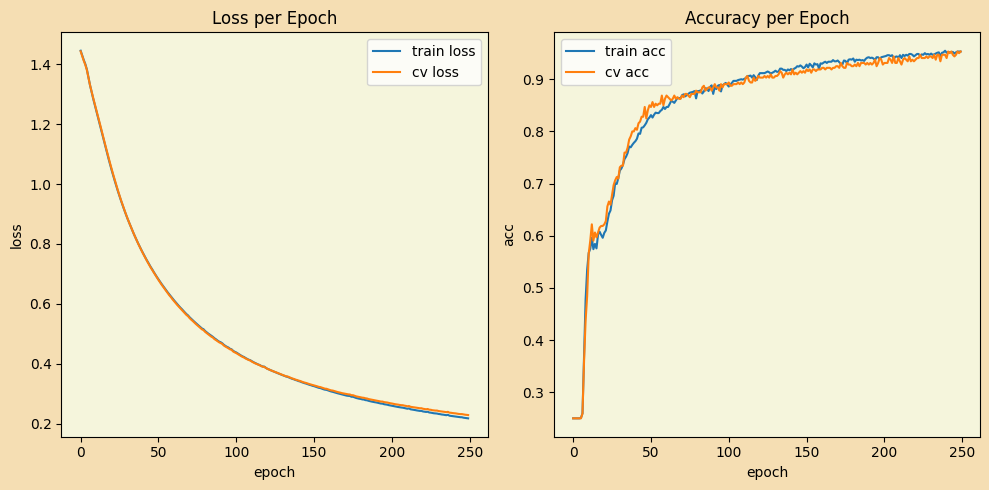

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss_hist, label='train loss')
ax[0].plot(cv_loss_hist, label='cv loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss per Epoch')
ax[0].legend()
ax[0].set_facecolor('#f5f5dc')



ax[1].plot(train_acc_hist, label='train acc')
ax[1].plot(cv_acc_hist, label='cv acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[1].set_title('Accuracy per Epoch')
ax[1].legend()
ax[1].set_facecolor('#f5f5dc')

fig.patch.set_facecolor('#F5DEB3')
plt.tight_layout()
plt.show()

## Final Evaluation

In [ ]:
test_loss, test_acc = get_loss_accuracy(test_loader, model, device, criterion)
print(f'Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}')

Test Loss: 0.2082 | Accuracy: 0.9625
